# Bias correct boundary conditions

Like in Naughten et al. 2023

In [1]:
import xarray as xr
import numpy as np
import cmocean
import sys
sys.path.append('/home/users/birgal/')
import pickle
from nemo_python_git.utils import fix_lon_range
from nemo_python_git.interpolation import regrid_array_cf, regrid_operator_cf, interp_latlon_cf
from nemo_python_git.file_io import find_cesm2_file, find_processed_cesm2_file
from nemo_python_git.constants import cesm2_ensemble_members
from nemo_python_git.ics_obcs import fill_ocean

In [2]:
base_folder = '/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/'

In [3]:
nemo_file = xr.open_dataset('/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/bathymetry/domain_cfg-20240305.nc').squeeze()

In [ ]:
file_path     = find_cesm2_file('LE2', 'TREFHT', 'atm', 'daily', '1011.001', 1850)

In [28]:
era5_file = xr.open_dataset('/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/ERA5-forcing/files/era5_t2m_1979_daily_averages.nc').mean(dim='time')
era5_file['longitude'] = fix_lon_range(era5_file['longitude'])
era5_ds = era5_file.rename({'longitude':'lon', 'latitude':'lat'}).sortby('lon')

In [ ]:
era5_mean_interp = interp_latlon_cf(era5_ds, nemo_file, pster_src=False, periodic_src=True, periodic_nemo=True, method='conservative')

In [ ]:
cesm2_file = xr.open_dataset(file_path)
cm2 = cesm2_file.isel(time=(cesm2_file.time.dt.year==1850)).mean(dim='time')
cm2_ds = cm2[['TREFHT']].sortby('lon') #cm2[['TREFHT']].sortby('lon')

In [ ]:
CESM2_mean_interp = interp_latlon_cf(cm2_ds, nemo_file, pster_src=False, periodic_src=True, periodic_nemo=True, method='conservative')

In [ ]:
CESM2_mean = cesm2_ensemble_time_mean_forcing('LE2', 'TREFHT', year_start=1850, year_end=1852)#, 
                                              # out_file='/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/climate-forcing/CESM2/LE2/processed/TREFHT_ensemble_mean.nc')

### Start with thermodynamic variables (TREFHT, QREFHT, FLDS, FSDS, PRECT, PRECS, PSL)

In [3]:
def era5_time_mean_forcing(variable, year_start=1979, year_end=2015, out_file=None):

    ERA5_ds   = xr.open_mfdataset(f'{base_folder}ERA5-forcing/files/era5_{variable}_*_daily_averages.nc')
    ERA5_ds   = ERA5_ds.isel(time=((ERA5_ds.time.dt.year <= year_end)*(ERA5_ds.time.dt.year >= year_start)))
    time_mean = ERA5_ds.mean(dim='time') 

    if out_file:
        time_mean.to_netcdf(out_file)
    return time_mean

In [4]:
# Function calculates the time-mean over specified year range for mean of all CESM2 ensemble members in the specified experiment
# !!!! but should I be running this on my pre-processed files? or on the original? --- changes what I read in and whether I need to correct lon range
# Input:
# - expt : string of CESM2 experiment name (e.g. 'LE2')
# - variable : string of forcing variable name
# - (optional) year_start : start year for time averaging
# - (optional) end_year   : end year for time averaging
# - (optional) out_file   : path to file to write time mean to NetCDF in case you want to store it
# - (optional) ensemble_members : list of strings of ensemble members to average (defaults to all the ones that have been downloaded)
def cesm2_ensemble_time_mean_forcing(expt, variable, year_start=1979, year_end=2015, out_file=None, ensemble_members=cesm2_ensemble_members):

    # calculate ensemble mean for each year
    year_mean = xr.Dataset()
    for year in range(year_start, year_end+1):
        files_to_open = []
        for ens in ensemble_members:
            file_path     = find_processed_cesm2_file(expt, variable, ens, year)
            files_to_open += [file_path]
        # calculate ensemble mean    
        ens_files = xr.open_mfdataset(files_to_open, concat_dim='ens', combine='nested')
        ens_year  = ens_files[variable].isel(time=(ens_files.time.dt.year==year))
        ens_mean  = ens_year.mean(dim=['time','ens']) # dimensions should be x,y
        # save ensemble mean to xarray dataset
        if year == year_start:
            year_mean = ens_mean
        else:
            year_mean = xr.concat([year_mean, ens_mean], dim='year')
            
    # and then calculate time-mean of all ensemble means:
    time_mean = year_mean.mean(dim='year')
    if out_file:
        time_mean.to_netcdf(out_file)
    
    return time_mean.to_dataset()

In [5]:
def atm_bias_correction(source, variable, expt='LE2', year_start=1979, year_end=2015, 
                        ensemble_mean_file=None, era5_mean_file=None,
                        nemo_grid='/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/bathymetry/domain_cfg-20240305.nc',
                        nemo_mask='/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/bathymetry/mesh_mask-20240305.nc',
                        out_folder='/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/climate-forcing/CESM2/LE2/processed/'):

    # NEMO configuration domain_cfg file for regridding
    nemo_grid_ds = xr.open_dataset(nemo_grid).squeeze()
    
    # process_forcing_for_correction(source, variable)
    if source=='CESM2':
        # Read in ensemble time mean (or calculate it)
        if ensemble_mean_file:
            CESM2_time_mean = xr.open_dataset(ensemble_mean_file)
        else:
            CESM2_time_mean = cesm2_ensemble_time_mean_forcing(expt, variable, year_start=year_start, year_end=year_end)

        # Read in time mean of ERA5 files (or calculate it)
        if era5_mean_file:
            ERA5_time_mean = xr.open_dataset(era5_mean_file)
        else:
            CESM2_to_ERA5_varnames = {'TREFHT':'t2m','FSDS':'rsds','FLDS':'rlds','QREFHT':'d2m'}
            varname = CESM2_to_ERA5_varnames[variable]
            ERA5_time_mean = era5_time_mean_forcing(varname, year_start=year_start, year_end=year_end)
            ERA5_time_mean = ERA5_time_mean.rename({varname:variable, 'longitude':'lon', 'latitude':'lat'})
        
        # Adjust the longitude and regrid time means to NEMO configuration grid, so that they can be used to bias correct
        ERA5_time_mean['lon'] = fix_lon_range(ERA5_time_mean['lon'])        
        CESM2_source = CESM2_time_mean.sortby('lon')
        ERA5_source  = ERA5_time_mean.sortby('lon')
        CESM2_mean_interp = interp_latlon_cf(CESM2_source, nemo_grid_ds, pster_src=False, periodic_src=True, periodic_nemo=True, method='conservative')
        ERA5_mean_interp  = interp_latlon_cf(ERA5_source , nemo_grid_ds, pster_src=False, periodic_src=True, periodic_nemo=True, method='conservative')
        
        print('seems to have made it through function', CESM2_mean_interp, ERA5_mean_interp)
        # thermodynamic correction
        if variable in ['TREFHT','QREFHT','FLDS','FSDS']:
            print('Correcting thermodynamics')
            out_file = f'{out_folder}{source}-{expt}_{variable}_bias_corr.nc'
            thermo_correction(variable, CESM2_mean_interp, ERA5_mean_interp, out_file)
        else:
            raise Exception(f'Variable {variable} does not need bias correction. Check that this is true.')
    else:
        raise Exception("Bias correction currently only set up to correct CESM2, sorry you'll need to write some more code")

    return

def thermo_correction(variable, CESM2_mean, ERA5_mean, out_file,
                      nemo_mask='/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/bathymetry/mesh_mask-20240305.nc'):
    
    # NEMO configuration domain_cfg file for regridding
    nemo_mask_ds = xr.open_dataset(nemo_mask).squeeze()

    # Calculate difference:
    bias = CESM2_mean - ERA5_mean
    # Mask land regions to zero:
    bias = xr.where(nemo_mask_ds.isel(nav_lev=0).tmask==0, 0, bias)

    # write to file
    bias.to_netcdf(out_file)
    
    return

In [ ]:
atm_bias_correction('CESM2', 'TREFHT', year_start=1979, year_end=2015)

In [26]:
CESM2_corr = xr.open_dataset('/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/climate-forcing/CESM2/LE2/processed/CESM2-LE2_TREFHT_bias_corr.nc')

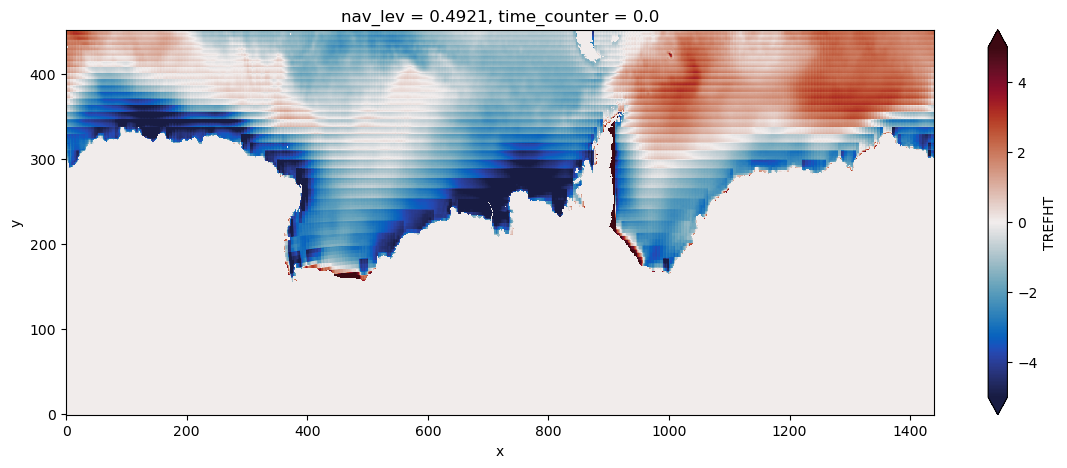

In [25]:
CESM2_corr.TREFHT.plot(figsize=(14,5), vmin=-5, vmax=5, cmap=cmocean.cm.balance)

In [9]:
nemo_mask_ds = xr.open_dataset('/gws/nopw/j04/anthrofail/birgal/NEMO_AIS/bathymetry/mesh_mask-20240305.nc').squeeze()

In [17]:
CESM2_source = CESM2_time_mean.sortby('lon')
CESM2_mean_interp = interp_latlon_cf(CESM2_source, nemo_file, pster_src=False, periodic_src=True, periodic_nemo=True, method='conservative')

## Adjust boundary conditions

In [15]:
ERA5_to_CESM2_varnames = {'t2m':'TREFHT','rsds':'FSDS','rlds':'FLDS','d2m':'QREFHT'}
CESM2_to_ERA5_varnames = {'TREFHT':'t2m','FSDS':'rsds','FLDS':'rlds','QREFHT':'d2m'}

In [ ]:
# Helper function to read and correct the CESM temperature and salinity in T/S space for a given experiment, year, month, boundary, and ensemble member. Both month and ens are 1-indexed.
def read_correct_cesm_ts_space (expt, bdry, ens, year, month, in_dir='/data/oceans_output/shelf/kaight/CESM_bias_correction/PAS/obcs/', 
                                obcs_dir='/data/oceans_output/shelf/kaight/ics_obcs/PAS/', 
                                mit_grid_dir='/data/oceans_output/shelf/kaight/archer2_mitgcm/PAS_grid/', return_raw=False):

    cesm_var_names = ['TEMP', 'SALT']
    obcs_dir = real_dir(obcs_dir)
    woa_var_names = ['theta', 'salt']
    woa_file_tail = '_woa_mon.bin'
    num_var = len(woa_var_names)
    num_bins = 100
    drho0 = 0.1  # Threshold density for mixed layer in WOA

    # Read the grids and slice to boundary
    mit_grid = Grid(mit_grid_dir)
    cesm_grid_file = find_cesm_file(expt, cesm_var_names[0], 'oce', 'monthly', ens, year)[0]
    cesm_lon, cesm_lat, cesm_z, cesm_nx, cesm_ny, cesm_nz = read_pop_grid(cesm_grid_file)
    # Need a few more fields to get the volume integrand
    cesm_dA = read_netcdf(cesm_grid_file, 'TAREA')*1e-4
    cesm_dz = read_netcdf(cesm_grid_file, 'dz')*1e-2
    cesm_dV = xy_to_xyz(cesm_dA, [cesm_nx, cesm_ny, cesm_nz])*z_to_xyz(cesm_dz, [cesm_nx, cesm_ny, cesm_z])
    loc0 = find_obcs_boundary(mit_grid, bdry)[0]
    if bdry in ['N']:
        direction = 'lat'
        dimensions = 'xzt'
        cesm_h_2d = cesm_lon
        mit_h = mit_grid.lon_1d
    hfac = get_hfac_bdry(mit_grid, bdry)
    if bdry == 'N':
        woa_dV_bdry = mit_grid.dV[:,-1,:]
    i1, i2, c1, c2 = interp_slice_helper_nonreg(cesm_lon, cesm_lat, loc0, direction)
    cesm_h_full = extract_slice_nonreg(cesm_h_2d, direction, i1, i2, c1, c2)
    cesm_h = trim_slice_to_grid(cesm_h_full, cesm_h_full, mit_grid, direction, warn=False)[0]
    cesm_nh = cesm_h.size
    cesm_dV_bdry = extract_slice_nonreg(cesm_dV, direction, i1, i2, c1, c2)
    cesm_dV_bdry = trim_slice_to_grid(cesm_dV_bdry, cesm_h_full, mit_grid, direction, warn=False)[0]

    # Read CESM data for this month and year and slice to boundary
    cesm_data = np.ma.empty([num_var, cesm_nz, cesm_nh])
    for v in range(num_var):
        file_path, t0_year, tf_year = find_cesm_file(expt, cesm_var_names[v], 'oce', 'monthly', ens, year)
        t0 = t0_year + month-1
        data_3d = read_netcdf(file_path, cesm_var_names[v], t_start=t0, t_end=t0+1)
        data_slice = extract_slice_nonreg(data_3d, direction, i1, i2, c1, c2)
        data_slice = trim_slice_to_grid(data_slice, cesm_h_full, mit_grid, direction, warn=False)[0]
        cesm_data[v,:] = data_slice
        cesm_mask = data_slice.mask
    
    # Read LENS climatology for this month
    cesm_clim = np.ma.empty([num_var, cesm_nz, cesm_nh])
    for v in range(num_var):
        file_path = cesm_file_head + cesm_var_names[v] + '_' + bdry + cesm_file_tail
        cesm_clim_tmp = read_binary(file_path, [cesm_nh, cesm_nh, cesm_nz], dimensions)[month-1,:]
        cesm_clim[v,:] = np.ma.masked_where(cesm_mask, cesm_clim_tmp)
    # Calculate anomalies from the climatology
    cesm_anom = cesm_data - cesm_clim

    # Read WOA climatology for this month
    woa_clim = np.ma.empty([num_var, mit_grid.nz, mit_h.size])
    for v in range(num_var):
        #file_path = obcs_dir + woa_var_names[v] + woa_file_mid + bdry
        file_path = obcs_dir + 'OB' + bdry + woa_var_names[v] + woa_file_tail
        woa_data_tmp = read_binary(file_path, [mit_grid.nx, mit_grid.ny, mit_grid.nz], dimensions)[month-1,:]
        woa_clim[v,:] = np.ma.masked_where(hfac==0, woa_data_tmp)
    # Select mixed layer
    woa_rho = potential_density('MDJWF', woa_clim[1,:], woa_clim[0,:])
    woa_mixed_layer = np.invert(hfac==0)  # Start with ocean mask
    woa_mld = np.zeros(woa_mixed_layer[0,:].shape)
    # Loop over water columns
    for j in range(mit_h.size):
        # Find first layer which exceeds the surface density plus drho0; everything above this is mixed layer (allows for possibility of density inversions in mixed layer which WOA has sometimes)
        k0 = np.where(woa_rho[:,j] < woa_rho[0,j] + drho0)[0][-1]
        woa_mixed_layer[k0:,j] = False
        woa_mld[j] = mit_grid.z[k0]

    # Calculate CESM volume and volume-weighted anomaly in T/S space
    bin_edges = np.linspace(0, 1, num=num_bins+1)
    bin_centres = 0.5*(bin_edges[:-1] + bin_edges[1:])
    cesm_temp_norm = normalise(cesm_clim[0,:])
    cesm_salt_norm = normalise(cesm_clim[1,:])
    cesm_volume_perbin = np.zeros([num_bins, num_bins])
    cesm_anom_integral_perbin = np.zeros([num_var, num_bins, num_bins])
    valid = np.invert(cesm_mask)
    for temp_val, salt_val, dV_val, temp_anom_val, salt_anom_val in zip(cesm_temp_norm[valid], cesm_salt_norm[valid], cesm_dV_bdry[valid], cesm_anom[0,:][valid], cesm_anom[1,:][valid]):
        temp_index = np.nonzero(bin_edges >= temp_val)[0][0]-1
        salt_index = np.nonzero(bin_edges >= salt_val)[0][0]-1
        cesm_volume_perbin[temp_index, salt_index] += dV_val
        anom_val = [temp_anom_val, salt_anom_val]
        for v in range(num_var):
            cesm_anom_integral_perbin[v, temp_index, salt_index] += anom_val[v]*dV_val
    cesm_volume_perbin = np.ma.masked_where(cesm_volume_perbin==0, cesm_volume_perbin)
    cesm_anom_integral_perbin = np.ma.masked_where(cesm_anom_integral_perbin==0, cesm_anom_integral_perbin)
    cesm_anom_ts = cesm_anom_integral_perbin/cesm_volume_perbin        
    # Now fill the missing spaces
    cesm_anom_ts_filled = np.zeros(cesm_anom_ts.shape)
    for v in range(num_var):
        # Distance-weighted mean of 10 nearest neighbours, then apply Gaussian filter of radius 2
        cesm_anom_ts_filled[v,:] = gaussian_filter(distance_weighted_nearest_neighbours(cesm_anom_ts[v,:], num_neighbours=10), 2)

    # Normalise T and S in WOA
    woa_temp_norm = normalise(woa_clim[0,:])
    woa_salt_norm = normalise(woa_clim[1,:])

    # Normalise WOA T and S
    woa_clim_norm = np.ma.empty(woa_clim.shape)
    for v in range(num_var):
        woa_clim_norm[v,:] = normalise(woa_clim[v,:])
    # Loop over points and find corresponding anomaly in normalised T/S space
    woa_anom_fulldepth = np.zeros(woa_clim.shape)
    j, k = np.meshgrid(np.arange(mit_h.size), np.arange(mit_grid.nz))
    valid = np.invert(woa_clim[0,:].mask)
    for temp_val, salt_val, k, j in zip(woa_temp_norm[valid], woa_salt_norm[valid], k[valid], j[valid]):
        temp_index = np.nonzero(bin_edges >= temp_val)[0][0]-1
        salt_index = np.nonzero(bin_edges >= salt_val)[0][0]-1
        for v in range(num_var):
            woa_anom_fulldepth[v,k,j] = cesm_anom_ts_filled[v, temp_index, salt_index]

    # Now get raw surface anomalies, interpolated from CESM horizontal grid to WOA
    woa_anom_sfc = np.ma.empty(woa_clim[:,0,:].shape)
    valid = np.invert(cesm_anom[0,0,:].mask)
    fill_value = -9999
    for v in range(num_var):
        # First do linear interpolation within the bounds of CESM land mask
        interp_f = interp1d(cesm_h[valid], cesm_anom[v,0,:][valid], kind='linear', fill_value=fill_value, bounds_error=False)
        woa_anom_tmp = interp_f(mit_h)
        # Do nearest-neighbour interpolation in the land mask
        woa_anom_tmp = fill_into_mask(np.ma.masked_where(woa_anom_tmp==fill_value, woa_anom_tmp), use_1d=True, use_3d=False, log=False)
        # Now mask out the land mask in WOA
        woa_anom_tmp = np.ma.masked_where(hfac[0,:]==0, woa_anom_tmp)
        woa_anom_sfc[v,:] = woa_anom_tmp
    # Linearly combine the surface anomalies with the T/S anomalies in the mixed layer, weighting from 1 at surface dropping off linearly with depth to 0 at the base of the mixed layer
    woa_depth = np.tile(np.expand_dims(np.copy(mit_grid.z), 1), (1, mit_h.size))
    weight = (woa_depth - woa_mld[None,:])/(mit_grid.z[0] - woa_mld[None,:])
    weight[np.invert(woa_mixed_layer)] = 0
    woa_anom = weight[None,:,:]*woa_anom_sfc[:,None,:] + (1-weight[None,:,:])*woa_anom_fulldepth
        
    # Add anomaly field to climatology for final corrected fields
    data_corrected = woa_clim + woa_anom
    # Set minimum temperature to not go below surface freezing point
    data_corrected[0,:] = np.maximum(data_corrected[0,:], Tf_ref)

    if return_raw:
        return data_corrected[0,:], data_corrected[1,:], cesm_data[0,:], cesm_data[1,:], cesm_h, cesm_z
    else:
        return data_corrected[0,:], data_corrected[1,:]


In [ ]:
# Read and correct T/S boundary conditions for all months and years, for a single ensemble member and experiment in CESM.
def process_cesm_obcs_ts (expt, ens, bdry_loc=['N', 'E', 'W'], start_year=None, end_year=None, out_dir='./'):

    out_dir = real_dir(out_dir)
    var_names = ['TEMP', 'SALT']
    num_var = len(var_names)
    bdry_loc = ['N']
    file_head = out_dir + expt + '_ens' + str(ens).zfill(3) + '_'

    for year in range(start_year, end_year+1):
        for bdry in bdry_loc:
            print('Processing '+str(year)+', '+bdry+' boundary')
            year_data = None
            # Process each month individually
            for month in range(months_per_year):
                print('...month '+str(month+1))
                temp_month, salt_month = read_correct_cesm_ts_space(expt, bdry, ens, year, month+1)
                month_data = [temp_month, salt_month]                        
                if year_data is None:
                    # Set up master array for the year now that we know the array sizes
                    year_data = np.empty([num_var, months_per_year, temp_month.shape[0], temp_month.shape[1]])
                # Fill land mask with nearest neighbours
                for v in range(num_var):
                    year_data[v,month,:,:] = fill_into_mask(month_data[v], use_3d=False, log=False)
            # Now write the whole year to file
            for v in range(num_var):
                file_path = out_dir + file_head + var_names[v] + '_' + bdry + '_' + str(year)
                write_binary(year_data[v,:], file_path)

In [ ]:
# Helper function to read and correct the given variable in CESM (other than temperature or salinity) for a given year, boundary, and ensemble member.
def read_correct_cesm_non_ts (expt, var, bdry, ens, year, in_dir='/data/oceans_output/shelf/kaight/CESM_bias_correction/PAS/obcs/', obcs_dir='/data/oceans_output/shelf/kaight/ics_obcs/PAS/', mit_grid_dir='/data/oceans_output/shelf/kaight/archer2_mitgcm/PAS_grid/', return_raw=False, return_sose_clim=False):

    cesm_file_head = in_dir + 'LENS_climatology_'
    cesm_file_tail = '_1998-2017'

    if (var == 'UVEL' and bdry in ['E', 'W']) or (var == 'VVEL' and bdry == 'N'):
        sose_file_tail = '_sose_corr.bin'
    else:
        sose_file_tail = '_sose.bin'
    sose_file = real_dir(obcs_dir) + 'OB' + bdry + sose_var + sose_file_tail
    if var in ['UVEL', 'VVEL']:
        domain = 'oce'
    else:
        domain = 'ice'
    if var in ['UVEL', 'uvel']:
        gtype = 'u'
    elif var in ['VVEL', 'vvel']:
        gtype = 'v'
    else:
        gtype = 't'

    mit_grid = Grid(mit_grid_dir)
    mit_lon, mit_lat = mit_grid.get_lon_lat(gtype=gtype, dim=1)
    hfac = get_hfac_bdry(mit_grid, bdry, gtype=gtype)
    if domain == 'ice':
        hfac = hfac[0,:]
    loc0_centre, loc0_edge = find_obcs_boundary(mit_grid, bdry)
    if (bdry in ['N', 'S'] and gtype == 'v') or (bdry in ['E', 'W'] and gtype == 'u'):
        loc0 = loc0_edge
    else:
        loc0 = loc0_centre
    
    cesm_grid_file = find_cesm_file(expt, var, domain, 'monthly', ens, year)[0]
    if domain == 'oce':
        cesm_tlon, cesm_tlat, cesm_ulon, cesm_ulat, cesm_z, cesm_nx, cesm_ny, cesm_nz = read_pop_grid(cesm_grid_file, return_ugrid=True)
    else:
        cesm_tlon, cesm_tlat, cesm_ulon, cesm_ulat, cesm_nx, cesm_ny = read_cice_grid(cesm_grid_file, return_ugrid=True)
        cesm_z = None
        cesm_nz = 1
    if gtype in ['u', 'v']:
        cesm_lon = cesm_ulon
        cesm_lat = cesm_ulat
    else:
        cesm_lon = cesm_tlon
        cesm_lat = cesm_tlat
    
    if bdry in ['N', 'S']:
        direction = 'lat'
        dimensions = 'x'
        cesm_h_2d = cesm_lon
        mit_h = mit_lon
    if domain == 'oce':
        dimensions += 'z'
    dimensions += 't'
    i1, i2, c1, c2 = interp_slice_helper_nonreg(cesm_lon, cesm_lat, loc0, direction)
    cesm_h_full = extract_slice_nonreg(cesm_h_2d, direction, i1, i2, c1, c2)
    cesm_h = trim_slice_to_grid(cesm_h_full, cesm_h_full, mit_grid, direction, warn=False)[0]
    cesm_nh = cesm_h.size

    # Read CESM data and extract slice
    file_path, t_start, t_end = find_cesm_file(expt, var, domain, 'monthly', ens, year)
    data_full = read_netcdf(file_path, var, t_start=t_start, t_end=t_end)
    if var in ['UVEL', 'VVEL', 'uvel', 'vvel', 'aice']:
        # Convert from cm/s to m/s, or percent to fraction
        data_full *= 1e-2
    data_slice = extract_slice_nonreg(data_full, direction, i1, i2, c1, c2)
    data_slice = trim_slice_to_grid(data_slice, cesm_h_full, mit_grid, direction, warn=False)[0]
    try:
        cesm_mask = np.invert(data_slice.mask[0,:])
    except(IndexError):
        # No special land mask for some sea ice variables
        cesm_mask = np.ones(data_slice[0,:].shape)

    # Read and subtract LENS climatology
    file_path = cesm_file_head + var + '_' + bdry + cesm_file_tail
    cesm_clim = read_binary(file_path, [cesm_nh, cesm_nh, cesm_nz], dimensions)
    data_slice_anom = data_slice - cesm_clim

    # Read SOSE climatology
    sose_clim = read_binary(sose_file, [mit_grid.nx, mit_grid.ny, mit_grid.nz], dimensions)
    for month in range(months_per_year):
        sose_clim_tmp = sose_clim[month,:]
        sose_clim_tmp[hfac==0] = 0
        sose_clim[month,:] = sose_clim_tmp

    # Interpolate to MIT grid
    if domain == 'oce':
        data_interp = np.ma.zeros([months_per_year, mit_grid.nz, mit_h.size])
    elif domain == 'ice':
        data_interp = np.ma.zeros([months_per_year, mit_h.size])
    for month in range(months_per_year):
        data_interp_tmp = interp_bdry(cesm_h, cesm_z, data_slice_anom[month,:], cesm_mask, mit_h, mit_grid.z, hfac, lon=(direction=='lat'), depth_dependent=(domain=='oce'))
        # Add SOSE climatology
        data_interp_tmp += sose_clim[month,:]
        # Fill MITgcm land mask with zeros
        index = hfac==0
        data_interp_tmp[index] = 0
        data_interp[month,:] = data_interp_tmp
    # Set physical limits
    if var in ['aice', 'hi', 'hs']:
        data_interp = np.maximum(data_interp, 0)
    if var == 'aice':
        data_interp = np.minimum(data_interp, 1)
    if var in ['hi', 'hs', 'uvel', 'vvel']:
        # Set to zero if (corrected) sea ice concentration is zero
        aice = read_correct_cesm_non_ts(expt, 'aice', bdry, ens, year, in_dir=in_dir, obcs_dir=obcs_dir, mit_grid_dir=mit_grid_dir)
        data_interp[aice==0] = 0

    if return_raw:
        if return_sose_clim:
            return data_interp, data_slice, cesm_h, cesm_z, sose_clim, mit_h, mit_grid.z
        else:
            return data_interp, data_slice, cesm_h, cesm_z
    else:
        if return_sose_clim:
            return data_interp, sose_clim, mit_h, mit_grid.z
        else:
            return data_interp    

In [ ]:
# Read and process all the other OBCS variables (besides T and S) for a given experiment, ensemble member and boundary in CESM.
def process_cesm_obcs_non_ts (expt, ens, bdry_loc=['N', 'E', 'W'], start_year=None, end_year=None, out_dir='./'):

    out_dir = real_dir(out_dir)
    var_names = ['UVEL', 'VVEL', 'aice', 'hi', 'hs', 'uvel', 'vvel']
    out_file_head = out_dir + expt + '_ens' + str(ens).zfill(3) + '_'
    if start_year is None:
        if expt == 'LENS':
            start_year = 1920
        else:
            start_year = 2006
    if end_year is None:
        if expt == 'MENS':
            end_year = 2080
        else:
            end_year = 2100

    for bdry in bdry_loc:
        for var in var_names:
            print('Processing '+var+' on '+bdry+' boundary')
            for year in range(start_year, end_year+1):
                data_interp = read_correct_cesm_non_ts(expt, var, bdry, ens, year)
                file_path = out_dir + out_file_head + var + '_' + bdry + '_' + str(year)
                write_binary(data_interp, file_path)